# Modelo B para clasificación de imágenes

#### **Jeffrey Daniel Leiva Cascante** 2021016720
#### **Richard Osvaldo León Chinchilla** 2019003759

En este notebook se plantea el **modelo B** para la clasificación de imágenes de Covid-19, se realizan primero 3 **Proof of Concept** con diferentes arquitecturas, se aplican técnicas cómo el **Dropout** e **Inception Modules** para mejorar la capacidad de clasificación de los modelos.

Se realizan las pruebas y se escoge el modelo con los mejores resultados para el subconjunto de pruebas; luego se procede a entrenar el modelo seleccionado con tres conjuntos de datos: el primero son los datos **crudos**, el segundo es de los datos con **bilateral filter** aplicado y el tercero es de los datos con el **canny edge filter** aplicado.

Los datos se cargan utilizando la herramienta de **DataLoader** provista por PyTorch. Además, se utilizan técnicas de **Data Augmentation** que permitan tener un mayor número de ejemplos de imágenes para el entrenamiento del modelo; por medio de la utilización del módulo de **transforms** que PyTorch provee.

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary


In [26]:
from google.colab import drive
drive.mount('/content/drive')
torch.cuda.is_available()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


False

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Carga de datos y utilización de transformers para las Proof of Concept.

Se carga un **20%** de los datos para realizar las tres **proof of concept** con los diferentes modelos que se van a plantear, se utiliza una semilla para asegurar la repetibilidad de los experimentos.

Se utiliza el módulo de **transforms** para aplicar transformaciones a las imágenes de entrada, en el caso de los datos de entrenamiento para las PoC se aplican técnicas de **Data Augmentation** cómo normalización, en este caso para no introducir más aleatoridad a las pruebas no se tienen inversiones o rotaciones, para el entrenamiento del modelo escogido a partir de las pruebas si se utilizarán estas técnicas.

Al utilizar un conjunto reducido de datos para las PoC se utiliza el DataLoader con un tamaño de **batch de 8** para ambos datasets.

In [34]:
train_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])


test_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),   # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])


# Definir las rutas a las carpetas
train_dir = './drive/MyDrive/Covid19-dataset/train'
test_dir = './drive/MyDrive/Covid19-dataset/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_data_transforms)

# Definir el tamaño del subconjunto que quieres usar
subset_size = 0.2  # Por ejemplo, usar el 20% de los datos

# Obtener los índices aleatorios para el subconjunto del conjunto de entrenamiento
np.random.seed(42)
train_size = len(train_dataset)
indices = list(range(train_size))
np.random.shuffle(indices)  # Mezclar los índices

subset_indices = indices[:int(subset_size * train_size)]  # Obtener el subconjunto

# Crear un SubsetRandomSampler con los índices seleccionados
train_sampler = SubsetRandomSampler(subset_indices)

# Obtener los índices aleatorios para el subconjunto del conjunto de testing
test_size = len(test_dataset)
indices_test = list(range(test_size))
np.random.shuffle(indices_test)  # Mezclar los índices

subset_indices_test = indices_test[:int(subset_size * test_size)]  # Obtener el subconjunto

# Crear un SubsetRandomSampler con los índices seleccionados
test_sampler = SubsetRandomSampler(subset_indices_test)

# Definir DataLoader para el conjunto de entrenamiento con el subconjunto de datos
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)

# También puedes crear un DataLoader para el conjunto de prueba completo
test_loader = DataLoader(test_dataset, batch_size=8, sampler=test_sampler)

## Propuesta de modelo 1

Para la propuesta #1 del modelo B tenemos la siguiente arquitectura:

- La primera capa es una capa de convolución de dos dimensiones que recibe la imágen de 1 canal (en escala de grises), aplica 64 filtros con tamaño de kernel 3 y padding de 1, lo que da como resultado la salida de 128x128x64.

- La segunda capa aplica max pooling con un kernel de 2 y stride de 2, lo que produce una salida de 64x64x64.

- Seguido de esto se tiene el módulo de Inception, que aplica varias operaciones de convolución y pooling en paralelo, lo que permite que el modelo aprenda mejor las características a diferentes niveles de complejidad. Cuenta con 4 ramas, en las que se aplican diversos tamaños de kernels y la salida de las ramas es de 64x64x128. Todas estas se concatenan y su salida es de 64x64x512.

- Después se vuelve a aplicar max pooling con kernel de 2 y stride de 2, lo que da cómo resultado una salida de 32x32x512, se hace el flatten de la misma y esta es la entrada de la primera capa fully connected.

- La capa primer capa fully connected  produce 128 canales de salida. La última capa tiene 128 canales de entrada y 3 de salida correspondientes a las tres categorías de imagenes.

**Se utiliza reLU cómo función de activación para las capas convolucionales y la primera capa fully connected**

In [35]:
class InceptionModuleOne(nn.Module):
  def __init__(self, chanels):
    super(InceptionModuleOne, self).__init__()

    self.branch1 = nn.Conv2d(chanels, 128, kernel_size=1)

    self.branch2 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU()
    )

    self.branch3 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=5, padding=2),
        nn.ReLU(),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
    )

  def forward(self,x):
    branch1 = F.relu(self.branch1(x))
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4],1)


class CNNModelBOne(nn.Module):
  def __init__(self):
    super(CNNModelBOne, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.inception = InceptionModuleOne(64)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(512 *32 *32, 128)
    self.fc2 = nn.Linear(128 , 3)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = self.inception(x)
    x = self.pool(x)
    x = self.dropout(x)
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x



### Proof of Concept Modelo 1

Se procede a realizar la prueba de concepto con el primer modelo planteado. Se visualiza el accuracy del conjunto de entrenamiento y validación por cada epoch. En este caso se realizan **50 epochs**.

Para el optimizador se utiliza el Stochastic Gradient Descent que nos facilita el módulo **optim**, además cómo función de pérdida se utiliza **Cross Entropy Loss**.

In [36]:

model = CNNModelBOne()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Setear el modelo a evalución
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Desabilitar gradientes para validación.
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Entrenar el modelo con validación.
train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=50)





Epoch 1/50, Train Loss: 1.0719, Train Accuracy: 36.00%, Val Loss: 1.0892, Val Accuracy: 23.08%
Epoch 2/50, Train Loss: 0.8743, Train Accuracy: 56.00%, Val Loss: 1.0763, Val Accuracy: 46.15%
Epoch 3/50, Train Loss: 0.6075, Train Accuracy: 80.00%, Val Loss: 1.0611, Val Accuracy: 46.15%
Epoch 4/50, Train Loss: 0.5270, Train Accuracy: 82.00%, Val Loss: 0.9796, Val Accuracy: 46.15%
Epoch 5/50, Train Loss: 0.4973, Train Accuracy: 86.00%, Val Loss: 0.8746, Val Accuracy: 61.54%
Epoch 6/50, Train Loss: 0.3053, Train Accuracy: 92.00%, Val Loss: 0.9555, Val Accuracy: 46.15%
Epoch 7/50, Train Loss: 0.2938, Train Accuracy: 88.00%, Val Loss: 0.7989, Val Accuracy: 61.54%
Epoch 8/50, Train Loss: 0.2605, Train Accuracy: 94.00%, Val Loss: 0.9668, Val Accuracy: 61.54%
Epoch 9/50, Train Loss: 0.2184, Train Accuracy: 90.00%, Val Loss: 0.8407, Val Accuracy: 61.54%
Epoch 10/50, Train Loss: 0.1752, Train Accuracy: 96.00%, Val Loss: 0.7197, Val Accuracy: 61.54%
Epoch 11/50, Train Loss: 0.1542, Train Accuracy: 

Se procede a mostrar las imágenes del set de testing así como la **etiqueta** que corresponde a cada una de ellas para posteriormente **comparar** los resultados de los modelos.

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
tensor([1, 0, 2, 1, 1, 0, 1, 2])


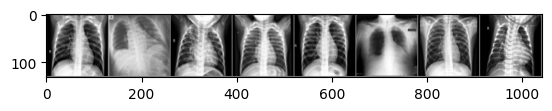

GroundTruth
Normal
Covid
Viral Pneumonia
Normal
Normal
Covid
Normal
Viral Pneumonia


In [37]:
classes = ('Covid', 'Normal','Viral Pneumonia')

#Para ver com se asignan las etiquetas a cada clase en el set de training
print(train_dataset.class_to_idx)
#Lo mismo pero para el set de testing
print(test_dataset.class_to_idx)

dataiter = iter(test_loader)
images, labels = next(dataiter)

print(labels)

def imshow(img):
    # Desnormalizar: (img * std) + mean
    img = img * 0.5 + 0.5  # Desnormalizar usando mean=0.5 y std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Añadir cmap si es necesario
    plt.show()

imshow(torchvision.utils.make_grid(images))

print('GroundTruth')
for j in range(8):
    print(f'{classes[labels[j]]:5s}')

Se muestran las predicciones de etiquetas realizadas por el modelo 1.

In [38]:
images = images.to(device)  # Mueve las imágenes a la GPU si está disponible

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ')

for j in range(8):
    print(f'{classes[predicted[j]]:5s}')


Predicted: 
Viral Pneumonia
Covid
Viral Pneumonia
Normal
Normal
Normal
Normal
Viral Pneumonia


Se proceded a calcular el porcentaje de acierto para las imágenes.

### Resultados de la prueba con la propuesta de modelo 1

En este caso, los resultados con el modelo 1 nos dan un 75% de accuracy con los datos de prueba, lo cual es un buen porcentaje para la pequeña cantidad de datos que se le han dado.

In [39]:
correct = 0
total = 0
# debido a que no estamos entrenando, no necesitamos calcular los gradientes para las salidas
with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device)
        # calcular outputs corriendo imagenes en la red
        outputs = model(images)
        # La clase con mayor valor es la que escogemos como salida
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy de la red en las 8 imagenes de test: {100 * correct // total} %')

Accuracy de la red en las 8 imagenes de test: 75 %


## Propuesta de modelo 2

Esta es la segunda propuesta de modelo B. Esta arquitectura de modelo es más compleja que la anterior, se aplican otras técnicas de normalización que ayuden al modelo a generalizar mejor los datos, en este se incluye un único módulo de Inception, además de varias capas de convolución, max pooling y dropout. Además se utiliza Batch Normalization, la cual es una técnica para normalizar las activaciones en capas intermedias de redes neuronales profundas, además ha demostrado mejorar el accuracy y acelerar el proceso de entrenamiento. (Bjork et al, 2018).


- En primer lugar se tiene una capa de convolución en el que se aplican 32 filtros, con un kernel de 3x3 y padding de 1, su salida es de 128x128x32.

- La segunda capa de convolución aplica 64 filtros con un kernel de 3 y padding de 1, su salida es de 128x128x64.

- Seguido se aplica max pooling con kernel de 2 y stride de 2, la salida es de 64x64x64.

- Luego se aplica el 1er dropout con una probabilidad de 0.2.

- Seguido de esto se tiene el módulo de Inception, que aplica varias operaciones de convolución y pooling en paralelo. Cuenta con 4 ramas, la primera produce 32 feature maps, la segunda 64, la tercera 64 y la cuarta 32, se concatenan y dan como salida 64x64x192.

- La tercera convolución produce una salida de 64x64x128.

- Luego se aplica de nuevo max pooling lo que reduce las dimensiones a 32x32x128.

- Seguido, se aplica la cuarta convolución, que produce como salida 32x32x256.

-Se aplica después el segundo dropout con una probabilidad de 0.25.

- Se hace el flatten, la primera fully connected produce 512 salidas, la segunda, la segunda produce 128 y la tercera produce 3 salidas correspondientes con las categorías de imágenes.


**Se aplica la función de activación reLU en las capas convolucionales y fully connected.**

**Después de cada convolución se aplica la función BatchNorm2d.**

In [40]:
class InceptionModuleTwo(nn.Module):
  def __init__(self, chanels):
    super(InceptionModuleTwo, self).__init__()

    self.branch1 = nn.Sequential(
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )

    self.branch2 = nn.Sequential(
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.branch3 = nn.Sequential(
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
    )

  def forward(self,x):
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4],1)


class CNNModelBTwo(nn.Module):
    def __init__(self):
        super(CNNModelBTwo, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.inception = InceptionModuleTwo(64)

        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(32 * 32 * 256, 512)
        self.dropout_fc = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(self.conv2(x))
        x = self.dropout1(x)
        x = self.inception(x)
        x = self.pool(self.conv3(x))
        x = self.conv4(x)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



#### Proof of Concept modelo 2


Se procede a realizar la prueba de concepto con el primer modelo planteado. Se visualiza el accuracy del conjunto de entrenamiento y validación por cada epoch. En este caso se realizan **50 epochs**.

Para el optimizador se utiliza el **Adam** que nos facilita el módulo **optim** en este caso, este nos puede ayudar a converger más rápido , además cómo función de pérdida se utiliza **Cross Entropy Loss**.

In [41]:

model = CNNModelBTwo()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Seteat el modelo para evaluación
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Desabilitar gradientes para validación
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Train Loss: 14.8366, Train Accuracy: 44.00%, Val Loss: 36.3042, Val Accuracy: 23.08%
Epoch 2/50, Train Loss: 4.2223, Train Accuracy: 70.00%, Val Loss: 21.6533, Val Accuracy: 7.69%
Epoch 3/50, Train Loss: 2.8370, Train Accuracy: 84.00%, Val Loss: 77.2138, Val Accuracy: 23.08%
Epoch 4/50, Train Loss: 1.5489, Train Accuracy: 86.00%, Val Loss: 19.4193, Val Accuracy: 23.08%
Epoch 5/50, Train Loss: 1.3463, Train Accuracy: 76.00%, Val Loss: 35.8143, Val Accuracy: 23.08%
Epoch 6/50, Train Loss: 0.3399, Train Accuracy: 94.00%, Val Loss: 64.1105, Val Accuracy: 23.08%
Epoch 7/50, Train Loss: 2.1044, Train Accuracy: 86.00%, Val Loss: 51.5912, Val Accuracy: 23.08%
Epoch 8/50, Train Loss: 1.2269, Train Accuracy: 90.00%, Val Loss: 26.0356, Val Accuracy: 23.08%
Epoch 9/50, Train Loss: 0.0256, Train Accuracy: 98.00%, Val Loss: 19.4870, Val Accuracy: 30.77%
Epoch 10/50, Train Loss: 0.1176, Train Accuracy: 98.00%, Val Loss: 9.0988, Val Accuracy: 30.77%
Epoch 11/50, Train Loss: 0.2348, Train A

### Resultados de la prueba con la propuesta de modelo 2

En este caso el accuracy es del 62% para las imágenes de prueba. Puede que el modelo en la práctica y con todos los datos tenga un mejor rendimiento al ser un poco más complejo y poder extraer mejor las características de los datos.

In [42]:
correct = 0
total = 0
# debido a que no estamos entrenando, no necesitamos calcular los gradientes para las salidas
with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device)
        # calcular outputs corriendo imagenes en la red
        outputs = model(images)
        # La clase con mayor valor es la que escogemos como salida
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy de la red en las 8 imagenes de test: {100 * correct // total} %')

Accuracy de la red en las 8 imagenes de test: 62 %


### Propuesta de modelo 3

Para la tercera propuesta se tiene un modelo más complejo, en este caso se utilizan dos módulos de Inception con un número mayor de filtros, de igual manera se aplican técnicas como batch normalization y dropout.

In [43]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, pool_proj):
        super(InceptionModule, self).__init__()

        # Branch 1: 1x1 Conv
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out1x1, kernel_size=1),
            nn.BatchNorm2d(out1x1),
            nn.ReLU()
        )

        # Branch 2: 1x1 Conv -> 3x3 Conv
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.BatchNorm2d(red3x3),
            nn.ReLU(),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out3x3),
            nn.ReLU()
        )

        # Branch 3: 1x1 Conv -> 5x5 Conv
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.BatchNorm2d(red5x5),
            nn.ReLU(),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out5x5),
            nn.ReLU()
        )

        # Branch 4: Max Pool -> 1x1 Conv
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU()
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)


class CNNModelWithTwoInception(nn.Module):
    def __init__(self):
        super(CNNModelWithTwoInception, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Primer Inception module
        self.inception1 = InceptionModule(64, 32, 32, 64, 16, 32, 32)

        # Segundo Inception module
        self.inception2 = InceptionModule(160, 64, 64, 128, 32, 64, 64)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.4)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected
        self.fc1 = nn.Linear(320, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        # Conv layers
        x = self.conv1(x)
        x = self.pool(self.conv2(x))

        # Primer Inception module
        x = self.inception1(x)

        # Pool después de primer inception
        x = self.pool(x)

        # Segundo Inception Module
        x = self.inception2(x)

        # Pooling
        x = self.pool(x)
        x = self.dropout1(x)

        # Global average pooling
        x = self.global_avg_pool(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Fully connected con dropout
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))

        # Salida
        x = self.fc3(x)

        return x


In [44]:

model = CNNModelWithTwoInception()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Setear el modelo a evalución
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Desabilitar gradientes para validación
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Entrenar el modelo con evaluación.
train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=50)

Epoch 1/50, Train Loss: 1.0547, Train Accuracy: 46.00%, Val Loss: 1.2304, Val Accuracy: 23.08%
Epoch 2/50, Train Loss: 0.8817, Train Accuracy: 58.00%, Val Loss: 2.2760, Val Accuracy: 23.08%
Epoch 3/50, Train Loss: 0.7830, Train Accuracy: 60.00%, Val Loss: 3.7660, Val Accuracy: 23.08%
Epoch 4/50, Train Loss: 0.7362, Train Accuracy: 62.00%, Val Loss: 5.1205, Val Accuracy: 23.08%
Epoch 5/50, Train Loss: 0.7625, Train Accuracy: 62.00%, Val Loss: 4.3580, Val Accuracy: 23.08%
Epoch 6/50, Train Loss: 0.6645, Train Accuracy: 64.00%, Val Loss: 2.1546, Val Accuracy: 23.08%
Epoch 7/50, Train Loss: 0.7678, Train Accuracy: 68.00%, Val Loss: 1.0871, Val Accuracy: 38.46%
Epoch 8/50, Train Loss: 0.5820, Train Accuracy: 70.00%, Val Loss: 0.7114, Val Accuracy: 53.85%
Epoch 9/50, Train Loss: 0.7021, Train Accuracy: 68.00%, Val Loss: 0.6181, Val Accuracy: 53.85%
Epoch 10/50, Train Loss: 0.5926, Train Accuracy: 76.00%, Val Loss: 0.6069, Val Accuracy: 61.54%
Epoch 11/50, Train Loss: 0.5465, Train Accuracy: 

In [45]:
correct = 0
total = 0
# debido a que no estamos entrenando, no necesitamos calcular los gradientes para las salidas
with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device)
        # calcular outputs corriendo imagenes en la red
        outputs = model(images)
        # La clase con mayor valor es la que escogemos como salida
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy de la red en las 8 imagenes de test: {100 * correct // total} %')

Accuracy de la red en las 8 imagenes de test: 100 %


# Modelo escogido

En base a los resultados expuestos anteriormente se estará utilizando el modelo 3, puesto que presento el mejor rendimiento en su PoC.

# Bibliografía

Bjorck, N., Gomes, C. P., Selman, B., & Weinberger, K. Q. (2018). Understanding batch normalization. Advances in neural information processing systems, 31.